## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [3]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2021-03-20 19:52:27--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.108.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.108.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.2’

train-test-data.zip 100%[===================>] 322.93M  97.5MB/s    in 3.5s    

2021-03-20 19:52:31 (91.5 MB/s) - ‘/data/train-test-data.zip.2’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [4]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [5]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm6): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=43264, out_features=1024, bias=True)
  (dense2):

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([
    Rescale((250,250)),
    RandomCrop(224),
    Normalize(),
    ToTensor()
])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [7]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [8]:
# load training data in batches
batch_size = 16

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [9]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [10]:
# load test data in batches
batch_size = 16

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [11]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [12]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [13]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

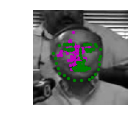

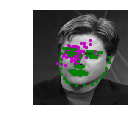

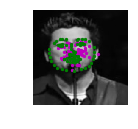

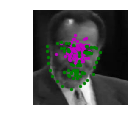

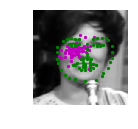

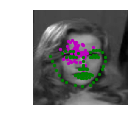

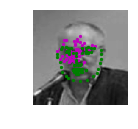

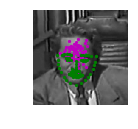

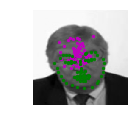

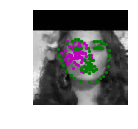

In [14]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [15]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(),lr=0.0001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [16]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [17]:
# train your network
n_epochs = 15 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.6052419900894165
Epoch: 1, Batch: 20, Avg. Loss: 0.5386821448802948
Epoch: 1, Batch: 30, Avg. Loss: 0.5502293676137924
Epoch: 1, Batch: 40, Avg. Loss: 0.5433144748210907
Epoch: 1, Batch: 50, Avg. Loss: 0.5576814591884613
Epoch: 1, Batch: 60, Avg. Loss: 0.5354633718729019
Epoch: 1, Batch: 70, Avg. Loss: 0.5325599014759064
Epoch: 1, Batch: 80, Avg. Loss: 0.5177431583404541
Epoch: 1, Batch: 90, Avg. Loss: 0.49638532996177676
Epoch: 1, Batch: 100, Avg. Loss: 0.5278872609138489
Epoch: 1, Batch: 110, Avg. Loss: 0.4889904290437698
Epoch: 1, Batch: 120, Avg. Loss: 0.4825762748718262
Epoch: 1, Batch: 130, Avg. Loss: 0.48066757023334505
Epoch: 1, Batch: 140, Avg. Loss: 0.47578308284282683
Epoch: 1, Batch: 150, Avg. Loss: 0.4582215756177902
Epoch: 1, Batch: 160, Avg. Loss: 0.42775280177593233
Epoch: 1, Batch: 170, Avg. Loss: 0.41376779079437254
Epoch: 1, Batch: 180, Avg. Loss: 0.41170597076416016
Epoch: 1, Batch: 190, Avg. Loss: 0.4096507877111435
Epoch: 1, Batch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.35619327425956726
Epoch: 2, Batch: 20, Avg. Loss: 0.3058162212371826
Epoch: 2, Batch: 30, Avg. Loss: 0.3027858898043633
Epoch: 2, Batch: 40, Avg. Loss: 0.277579627931118
Epoch: 2, Batch: 50, Avg. Loss: 0.27932093739509584
Epoch: 2, Batch: 60, Avg. Loss: 0.2546796664595604
Epoch: 2, Batch: 70, Avg. Loss: 0.22109152674674987
Epoch: 2, Batch: 80, Avg. Loss: 0.2083518996834755
Epoch: 2, Batch: 90, Avg. Loss: 0.19661990106105803
Epoch: 2, Batch: 100, Avg. Loss: 0.21804437041282654
Epoch: 2, Batch: 110, Avg. Loss: 0.18691926151514054
Epoch: 2, Batch: 120, Avg. Loss: 0.1836731806397438
Epoch: 2, Batch: 130, Avg. Loss: 0.18978396207094192
Epoch: 2, Batch: 140, Avg. Loss: 0.18196057975292207
Epoch: 2, Batch: 150, Avg. Loss: 0.1589112713932991
Epoch: 2, Batch: 160, Avg. Loss: 0.15504124015569687
Epoch: 2, Batch: 170, Avg. Loss: 0.1480732522904873
Epoch: 2, Batch: 180, Avg. Loss: 0.14719155728816985
Epoch: 2, Batch: 190, Avg. Loss: 0.15183315873146058
Epoch: 2, B

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.1374880038201809
Epoch: 3, Batch: 20, Avg. Loss: 0.1266028642654419
Epoch: 3, Batch: 30, Avg. Loss: 0.14770380705595015
Epoch: 3, Batch: 40, Avg. Loss: 0.1238471232354641
Epoch: 3, Batch: 50, Avg. Loss: 0.13565893471240997
Epoch: 3, Batch: 60, Avg. Loss: 0.13286249041557313
Epoch: 3, Batch: 70, Avg. Loss: 0.12478632107377052
Epoch: 3, Batch: 80, Avg. Loss: 0.12565208226442337
Epoch: 3, Batch: 90, Avg. Loss: 0.12301245629787445
Epoch: 3, Batch: 100, Avg. Loss: 0.13607699126005174
Epoch: 3, Batch: 110, Avg. Loss: 0.11890686601400376
Epoch: 3, Batch: 120, Avg. Loss: 0.12061863914132118
Epoch: 3, Batch: 130, Avg. Loss: 0.12086598575115204
Epoch: 3, Batch: 140, Avg. Loss: 0.10670096948742866
Epoch: 3, Batch: 150, Avg. Loss: 0.12225394770503044
Epoch: 3, Batch: 160, Avg. Loss: 0.12391954883933068
Epoch: 3, Batch: 170, Avg. Loss: 0.11629794836044312
Epoch: 3, Batch: 180, Avg. Loss: 0.10952556133270264
Epoch: 3, Batch: 190, Avg. Loss: 0.12080155089497566
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.12078128904104232
Epoch: 4, Batch: 20, Avg. Loss: 0.10270050317049026
Epoch: 4, Batch: 30, Avg. Loss: 0.10767597556114197
Epoch: 4, Batch: 40, Avg. Loss: 0.11316355094313621
Epoch: 4, Batch: 50, Avg. Loss: 0.10751443356275558
Epoch: 4, Batch: 60, Avg. Loss: 0.11091149374842643
Epoch: 4, Batch: 70, Avg. Loss: 0.10041838511824608
Epoch: 4, Batch: 80, Avg. Loss: 0.10296175852417946
Epoch: 4, Batch: 90, Avg. Loss: 0.11723640486598015
Epoch: 4, Batch: 100, Avg. Loss: 0.1002748116850853
Epoch: 4, Batch: 110, Avg. Loss: 0.11114231124520302
Epoch: 4, Batch: 120, Avg. Loss: 0.10010239109396935
Epoch: 4, Batch: 130, Avg. Loss: 0.10787392556667327
Epoch: 4, Batch: 140, Avg. Loss: 0.10228265449404716
Epoch: 4, Batch: 150, Avg. Loss: 0.10078269168734551
Epoch: 4, Batch: 160, Avg. Loss: 0.10344895496964454
Epoch: 4, Batch: 170, Avg. Loss: 0.10299863740801811
Epoch: 4, Batch: 180, Avg. Loss: 0.10089337304234505
Epoch: 4, Batch: 190, Avg. Loss: 0.1042991392314434
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.09199761375784873
Epoch: 5, Batch: 20, Avg. Loss: 0.09655414819717408
Epoch: 5, Batch: 30, Avg. Loss: 0.09116997495293618
Epoch: 5, Batch: 40, Avg. Loss: 0.1051485113799572
Epoch: 5, Batch: 50, Avg. Loss: 0.11368260234594345
Epoch: 5, Batch: 60, Avg. Loss: 0.08178221881389618
Epoch: 5, Batch: 70, Avg. Loss: 0.0953241042792797
Epoch: 5, Batch: 80, Avg. Loss: 0.09101804345846176
Epoch: 5, Batch: 90, Avg. Loss: 0.09616322070360184
Epoch: 5, Batch: 100, Avg. Loss: 0.109554985165596
Epoch: 5, Batch: 110, Avg. Loss: 0.08692313730716705
Epoch: 5, Batch: 120, Avg. Loss: 0.09038820639252662
Epoch: 5, Batch: 130, Avg. Loss: 0.08752857521176338
Epoch: 5, Batch: 140, Avg. Loss: 0.0904943585395813
Epoch: 5, Batch: 150, Avg. Loss: 0.08214334324002266
Epoch: 5, Batch: 160, Avg. Loss: 0.09167904928326606
Epoch: 5, Batch: 170, Avg. Loss: 0.08394067585468293
Epoch: 5, Batch: 180, Avg. Loss: 0.08406776264309883
Epoch: 5, Batch: 190, Avg. Loss: 0.07934814803302288
Epoch: 

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.09671084508299828
Epoch: 6, Batch: 20, Avg. Loss: 0.08984236121177673
Epoch: 6, Batch: 30, Avg. Loss: 0.08139068074524403
Epoch: 6, Batch: 40, Avg. Loss: 0.08525895699858665
Epoch: 6, Batch: 50, Avg. Loss: 0.07688113003969192
Epoch: 6, Batch: 60, Avg. Loss: 0.07793544679880142
Epoch: 6, Batch: 70, Avg. Loss: 0.07704190276563168
Epoch: 6, Batch: 80, Avg. Loss: 0.07494057491421699
Epoch: 6, Batch: 90, Avg. Loss: 0.07635700404644012
Epoch: 6, Batch: 100, Avg. Loss: 0.07870368324220181
Epoch: 6, Batch: 110, Avg. Loss: 0.07647963315248489
Epoch: 6, Batch: 120, Avg. Loss: 0.0789385586977005
Epoch: 6, Batch: 130, Avg. Loss: 0.08085399605333805
Epoch: 6, Batch: 140, Avg. Loss: 0.06878042332828045
Epoch: 6, Batch: 150, Avg. Loss: 0.07417561188340187
Epoch: 6, Batch: 160, Avg. Loss: 0.07377950437366962
Epoch: 6, Batch: 170, Avg. Loss: 0.08284981176257133
Epoch: 6, Batch: 180, Avg. Loss: 0.07032438032329083
Epoch: 6, Batch: 190, Avg. Loss: 0.06478135697543622
Epo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.07228302322328091
Epoch: 7, Batch: 20, Avg. Loss: 0.07136246785521508
Epoch: 7, Batch: 30, Avg. Loss: 0.07475290074944496
Epoch: 7, Batch: 40, Avg. Loss: 0.0658227488398552
Epoch: 7, Batch: 50, Avg. Loss: 0.07542068660259246
Epoch: 7, Batch: 60, Avg. Loss: 0.06488992050290107
Epoch: 7, Batch: 70, Avg. Loss: 0.07960465811192989
Epoch: 7, Batch: 80, Avg. Loss: 0.07319971621036529
Epoch: 7, Batch: 90, Avg. Loss: 0.06776290982961655
Epoch: 7, Batch: 100, Avg. Loss: 0.06345603652298451
Epoch: 7, Batch: 110, Avg. Loss: 0.06798256486654282
Epoch: 7, Batch: 120, Avg. Loss: 0.07886950671672821
Epoch: 7, Batch: 130, Avg. Loss: 0.0694927129894495
Epoch: 7, Batch: 140, Avg. Loss: 0.054460243135690686
Epoch: 7, Batch: 150, Avg. Loss: 0.0843324925750494
Epoch: 7, Batch: 160, Avg. Loss: 0.0688197199255228
Epoch: 7, Batch: 170, Avg. Loss: 0.06862984448671341
Epoch: 7, Batch: 180, Avg. Loss: 0.06509456746280193
Epoch: 7, Batch: 190, Avg. Loss: 0.07325535714626312
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.06481048166751861
Epoch: 8, Batch: 20, Avg. Loss: 0.07393098026514053
Epoch: 8, Batch: 30, Avg. Loss: 0.0780598096549511
Epoch: 8, Batch: 40, Avg. Loss: 0.06235247515141964
Epoch: 8, Batch: 50, Avg. Loss: 0.055043209344148636
Epoch: 8, Batch: 60, Avg. Loss: 0.06465690694749356
Epoch: 8, Batch: 70, Avg. Loss: 0.062002642452716826
Epoch: 8, Batch: 80, Avg. Loss: 0.06653598546981812
Epoch: 8, Batch: 90, Avg. Loss: 0.0668463222682476
Epoch: 8, Batch: 100, Avg. Loss: 0.061608821898698804
Epoch: 8, Batch: 110, Avg. Loss: 0.0669023897498846
Epoch: 8, Batch: 120, Avg. Loss: 0.06492876969277858
Epoch: 8, Batch: 130, Avg. Loss: 0.0642168078571558
Epoch: 8, Batch: 140, Avg. Loss: 0.05877245031297207
Epoch: 8, Batch: 150, Avg. Loss: 0.07391282059252262
Epoch: 8, Batch: 160, Avg. Loss: 0.07074748687446117
Epoch: 8, Batch: 170, Avg. Loss: 0.06447581015527248
Epoch: 8, Batch: 180, Avg. Loss: 0.055436789989471436
Epoch: 8, Batch: 190, Avg. Loss: 0.05787771157920361
Ep

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.0584157831966877
Epoch: 9, Batch: 20, Avg. Loss: 0.07099433615803719
Epoch: 9, Batch: 30, Avg. Loss: 0.05593111086636782
Epoch: 9, Batch: 40, Avg. Loss: 0.057509252801537514
Epoch: 9, Batch: 50, Avg. Loss: 0.0627891018986702
Epoch: 9, Batch: 60, Avg. Loss: 0.06341197490692138
Epoch: 9, Batch: 70, Avg. Loss: 0.06054983995854855
Epoch: 9, Batch: 80, Avg. Loss: 0.05353148654103279
Epoch: 9, Batch: 90, Avg. Loss: 0.06426975317299366
Epoch: 9, Batch: 100, Avg. Loss: 0.0680489718914032
Epoch: 9, Batch: 110, Avg. Loss: 0.059757405519485475
Epoch: 9, Batch: 120, Avg. Loss: 0.05795203261077404
Epoch: 9, Batch: 130, Avg. Loss: 0.05556211955845356
Epoch: 9, Batch: 140, Avg. Loss: 0.05223536863923073
Epoch: 9, Batch: 150, Avg. Loss: 0.059050023555755615
Epoch: 9, Batch: 160, Avg. Loss: 0.052557580173015594
Epoch: 9, Batch: 170, Avg. Loss: 0.054720675013959406
Epoch: 9, Batch: 180, Avg. Loss: 0.050897442549467084
Epoch: 9, Batch: 190, Avg. Loss: 0.0526419885456562


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.04732603095471859
Epoch: 10, Batch: 20, Avg. Loss: 0.061491527035832404
Epoch: 10, Batch: 30, Avg. Loss: 0.051332336664199826
Epoch: 10, Batch: 40, Avg. Loss: 0.0518967017531395
Epoch: 10, Batch: 50, Avg. Loss: 0.058762728422880176
Epoch: 10, Batch: 60, Avg. Loss: 0.05486564710736275
Epoch: 10, Batch: 70, Avg. Loss: 0.046022658422589305
Epoch: 10, Batch: 80, Avg. Loss: 0.05691169239580631
Epoch: 10, Batch: 90, Avg. Loss: 0.05280342698097229
Epoch: 10, Batch: 100, Avg. Loss: 0.05075055807828903
Epoch: 10, Batch: 110, Avg. Loss: 0.042174610495567325
Epoch: 10, Batch: 120, Avg. Loss: 0.050083497911691664
Epoch: 10, Batch: 130, Avg. Loss: 0.05244692452251911
Epoch: 10, Batch: 140, Avg. Loss: 0.046637114882469174
Epoch: 10, Batch: 150, Avg. Loss: 0.05078993439674377
Epoch: 10, Batch: 160, Avg. Loss: 0.05384969338774681
Epoch: 10, Batch: 170, Avg. Loss: 0.050736353173851965
Epoch: 10, Batch: 180, Avg. Loss: 0.05300840847194195
Epoch: 10, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 11, Batch: 10, Avg. Loss: 0.044196240976452826
Epoch: 11, Batch: 20, Avg. Loss: 0.059077249839901924
Epoch: 11, Batch: 30, Avg. Loss: 0.0511121803894639
Epoch: 11, Batch: 40, Avg. Loss: 0.05116682276129723
Epoch: 11, Batch: 50, Avg. Loss: 0.050661345943808556
Epoch: 11, Batch: 60, Avg. Loss: 0.045489126816391945
Epoch: 11, Batch: 70, Avg. Loss: 0.04666735306382179
Epoch: 11, Batch: 80, Avg. Loss: 0.05623641014099121
Epoch: 11, Batch: 90, Avg. Loss: 0.05197214260697365
Epoch: 11, Batch: 100, Avg. Loss: 0.053474534302949905
Epoch: 11, Batch: 110, Avg. Loss: 0.04958091266453266
Epoch: 11, Batch: 120, Avg. Loss: 0.04836307279765606
Epoch: 11, Batch: 130, Avg. Loss: 0.052940146252512935
Epoch: 11, Batch: 140, Avg. Loss: 0.04896502681076527
Epoch: 11, Batch: 150, Avg. Loss: 0.052472572401165964
Epoch: 11, Batch: 160, Avg. Loss: 0.05941685363650322
Epoch: 11, Batch: 170, Avg. Loss: 0.03962310254573822
Epoch: 11, Batch: 180, Avg. Loss: 0.047269449755549434
Epoch: 11, Batch: 190, Avg. Lo

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 12, Batch: 10, Avg. Loss: 0.04898835904896259
Epoch: 12, Batch: 20, Avg. Loss: 0.04212386067956686
Epoch: 12, Batch: 30, Avg. Loss: 0.047219303995370866
Epoch: 12, Batch: 40, Avg. Loss: 0.04415532015264034
Epoch: 12, Batch: 50, Avg. Loss: 0.06272817067801953
Epoch: 12, Batch: 60, Avg. Loss: 0.05348891355097294
Epoch: 12, Batch: 70, Avg. Loss: 0.0559357900172472
Epoch: 12, Batch: 80, Avg. Loss: 0.05506417527794838
Epoch: 12, Batch: 90, Avg. Loss: 0.04179547987878322
Epoch: 12, Batch: 100, Avg. Loss: 0.05085873547941446
Epoch: 12, Batch: 110, Avg. Loss: 0.03944551981985569
Epoch: 12, Batch: 120, Avg. Loss: 0.05086616780608892
Epoch: 12, Batch: 130, Avg. Loss: 0.05176363289356232
Epoch: 12, Batch: 140, Avg. Loss: 0.039801800064742564
Epoch: 12, Batch: 150, Avg. Loss: 0.046527180820703506
Epoch: 12, Batch: 160, Avg. Loss: 0.03792824260890484
Epoch: 12, Batch: 170, Avg. Loss: 0.04797735810279846
Epoch: 12, Batch: 180, Avg. Loss: 0.04915502667427063
Epoch: 12, Batch: 190, Avg. Loss: 0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 13, Batch: 10, Avg. Loss: 0.04675181284546852
Epoch: 13, Batch: 20, Avg. Loss: 0.04994385614991188
Epoch: 13, Batch: 30, Avg. Loss: 0.04660400189459324
Epoch: 13, Batch: 40, Avg. Loss: 0.04577966704964638
Epoch: 13, Batch: 50, Avg. Loss: 0.04532540626823902
Epoch: 13, Batch: 60, Avg. Loss: 0.03943480756133795
Epoch: 13, Batch: 70, Avg. Loss: 0.04673842880874872
Epoch: 13, Batch: 80, Avg. Loss: 0.05446084588766098
Epoch: 13, Batch: 90, Avg. Loss: 0.0427746944129467
Epoch: 13, Batch: 100, Avg. Loss: 0.0447748102247715
Epoch: 13, Batch: 110, Avg. Loss: 0.041701449640095235
Epoch: 13, Batch: 120, Avg. Loss: 0.04664294421672821
Epoch: 13, Batch: 130, Avg. Loss: 0.05102161262184381
Epoch: 13, Batch: 140, Avg. Loss: 0.04116876311600208
Epoch: 13, Batch: 150, Avg. Loss: 0.041037209890782834
Epoch: 13, Batch: 160, Avg. Loss: 0.06199766509234905
Epoch: 13, Batch: 170, Avg. Loss: 0.04788853675127029
Epoch: 13, Batch: 180, Avg. Loss: 0.04158466588705778
Epoch: 13, Batch: 190, Avg. Loss: 0.0

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 14, Batch: 10, Avg. Loss: 0.04557245746254921
Epoch: 14, Batch: 20, Avg. Loss: 0.0481070414185524
Epoch: 14, Batch: 30, Avg. Loss: 0.0365880236029625
Epoch: 14, Batch: 40, Avg. Loss: 0.0418061850592494
Epoch: 14, Batch: 50, Avg. Loss: 0.040871952287852766
Epoch: 14, Batch: 60, Avg. Loss: 0.036971996538341045
Epoch: 14, Batch: 70, Avg. Loss: 0.04269575774669647
Epoch: 14, Batch: 80, Avg. Loss: 0.04412572793662548
Epoch: 14, Batch: 90, Avg. Loss: 0.045069961436092855
Epoch: 14, Batch: 100, Avg. Loss: 0.04432046413421631
Epoch: 14, Batch: 110, Avg. Loss: 0.039112269133329394
Epoch: 14, Batch: 120, Avg. Loss: 0.049850734695792195
Epoch: 14, Batch: 130, Avg. Loss: 0.04370020683854818
Epoch: 14, Batch: 140, Avg. Loss: 0.047868493013083935
Epoch: 14, Batch: 150, Avg. Loss: 0.043409434333443644
Epoch: 14, Batch: 160, Avg. Loss: 0.04189820773899555
Epoch: 14, Batch: 170, Avg. Loss: 0.039727313071489335
Epoch: 14, Batch: 180, Avg. Loss: 0.041755151376128195
Epoch: 14, Batch: 190, Avg. Los

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 15, Batch: 10, Avg. Loss: 0.03827759549021721
Epoch: 15, Batch: 20, Avg. Loss: 0.0346333933994174
Epoch: 15, Batch: 30, Avg. Loss: 0.046734636276960374
Epoch: 15, Batch: 40, Avg. Loss: 0.036410906724631785
Epoch: 15, Batch: 50, Avg. Loss: 0.04300874974578619
Epoch: 15, Batch: 60, Avg. Loss: 0.042059645801782605
Epoch: 15, Batch: 70, Avg. Loss: 0.04373077731579542
Epoch: 15, Batch: 80, Avg. Loss: 0.0381121451035142
Epoch: 15, Batch: 90, Avg. Loss: 0.05269931871443987
Epoch: 15, Batch: 100, Avg. Loss: 0.05126571767032147
Epoch: 15, Batch: 110, Avg. Loss: 0.04345433115959167
Epoch: 15, Batch: 120, Avg. Loss: 0.04429067336022854
Epoch: 15, Batch: 130, Avg. Loss: 0.04193879682570696
Epoch: 15, Batch: 140, Avg. Loss: 0.03577566947788
Epoch: 15, Batch: 150, Avg. Loss: 0.046404939889907834
Epoch: 15, Batch: 160, Avg. Loss: 0.052215253189206126
Epoch: 15, Batch: 170, Avg. Loss: 0.0380409961566329
Epoch: 15, Batch: 180, Avg. Loss: 0.04639530293643475
Epoch: 15, Batch: 190, Avg. Loss: 0.04

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [18]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([16, 1, 224, 224])
torch.Size([16, 68, 2])
torch.Size([16, 68, 2])


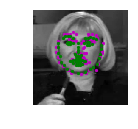

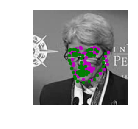

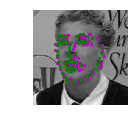

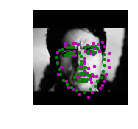

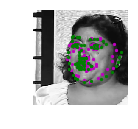

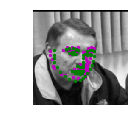

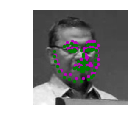

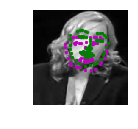

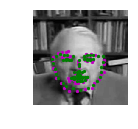

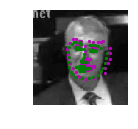

In [19]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [20]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_Final.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I used Adam optimizer because it speeds up convergence by adding the exponential weighted average of the gradients, and their square to the learning procedure, with a learning rate of 0.0001 relatively small to avoid overshooting, the choice of the loss function was MSE loss (mean square error) was due to that I didn't add an activation at the end because the task of this neural network is regression not classification as it predicts x,y coordinates of facial keypoints, so that the error is the sum of the distances between the predicted keypoints' positions and the true keypoints' positions.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: i started my network from the refrenced NaimishNet for facial keypoints detection, at first I didn't add batch norm but then I added it and it improved training a lot.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I started with a number of epochs of 15, and it performed just fine, the batch size I chose was 32 to use the GPU efficiently but it exceeded the memory, so I had to decrease it to 16.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[ 0.18736286  0.02508944  0.16298065 -0.1959523 ]
 [ 0.04988245 -0.1857824   0.14157052  0.16239314]
 [ 0.03250417  0.21670458 -0.15377356  0.0132989 ]
 [-0.23296311 -0.23845185 -0.20631805  0.18461762]]
(4, 4)


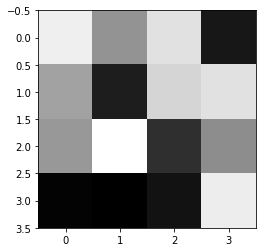

In [25]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 1

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

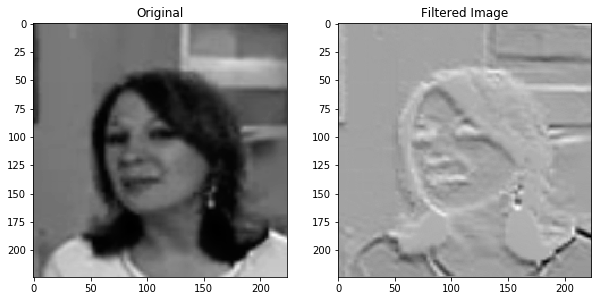

In [26]:
import cv2
##TODO: load in and display any image from the transformed test dataset
img = test_images[11].data.squeeze().numpy()
my_filter=w[filter_index][0]
filtered_img=cv2.filter2D(img,-1,my_filter)
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('Original')
ax1.imshow(img, cmap='gray')
ax2.set_title('Filtered Image')
ax2.imshow(filtered_img, cmap='gray')

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: This filter as shown above detects sharp edges in the image.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!